In [1]:
!pip install torchdiffeq

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
import torch 
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchdiffeq import odeint as odeintTorch

In [3]:
# generating test data
w = -0.0+1.0j
x0 = 1.5+2.5j
dt_integration =0.01
T0 = 0
Tf = 10
time = np.arange(0,Tf+0.000001,dt_integration)

True_sol_test = []
for i in range(len(time)):
    True_sol_test.append(x0*np.exp(w*T0)*np.exp(w*time[i]))
True_sol_test = np.array(True_sol_test)

In [4]:
# generating training data
w = -0.0+1.0j
x0 = 0.5+0.5j
dt_integration =0.01
T0 = 0
Tf = 100
time = np.arange(0,Tf+0.000001,dt_integration)

True_sol = []
for i in range(len(time)):
    True_sol.append(x0*np.exp(w*T0)*np.exp(w*time[i]))
True_sol = np.array(True_sol)

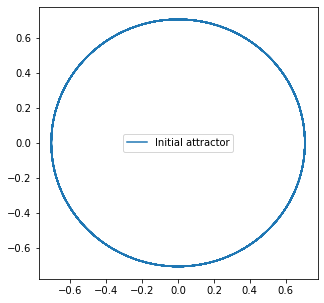

In [5]:
fig = plt.figure(figsize = (5,5))

plt.plot(True_sol.real,True_sol.imag,label = 'Initial attractor')
plt.legend()

In [6]:
device = 'cpu'
params = {}#NN parameters 
params['transition_layers']=5
params['bi_linear_layers']=3
params['dim_hidden_linear'] = 3
params['dim_input']=1
params['dim_observations'] = 1
params['dim_output']=1
params['dim_hidden']=5
params['dt_integration']=dt_integration
params['ntrain']=[1000]
params['pretrained']=False
params['path']='NODE_RK4_Lorend_dt_02'
params['lr']=0.001

In [7]:
# modeling only the real part 
x      = torch.from_numpy(True_sol.real).float().unsqueeze(-1).unsqueeze(0)[:,:-1,:].to(device)
y      = torch.from_numpy(True_sol.real).float().unsqueeze(-1).unsqueeze(0)[:,1:,:].to(device)
x_test = torch.from_numpy(True_sol_test.real).float().unsqueeze(-1).unsqueeze(0)[:,1:,:].to(device)

In [8]:
class NODE_model(torch.nn.Module):
        def __init__(self, params):
            super(NODE_model, self).__init__()
            self.linearCell   = torch.nn.Linear(params['dim_input'], params['dim_hidden_linear']).to(device) 
            self.BlinearCell1 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1).to(device) for i in range(params['bi_linear_layers'])])
            self.BlinearCell2 = torch.nn.ModuleList([torch.nn.Linear(params['dim_input'], 1).to(device) for i in range(params['bi_linear_layers'])])
            augmented_size    = params['bi_linear_layers'] + params['dim_hidden_linear']
            self.transLayers = torch.nn.ModuleList([torch.nn.Linear(augmented_size, params['dim_output']).to(device)])
            self.transLayers.extend([torch.nn.Linear(params['dim_output'], params['dim_output']).to(device) for i in range(1, params['transition_layers'])])
            self.outputLayer  = torch.nn.Linear(params['dim_output'], params['dim_output']).to(device)
        def forward(self,dt, inp):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
            BP_outp = (torch.zeros((inp.size()[0],params['bi_linear_layers'])).to(device))
            L_outp   = self.linearCell(inp)
            for i in range((params['bi_linear_layers'])):
                BP_outp[:,i]=self.BlinearCell1[i](inp)[:,0]*self.BlinearCell2[i](inp)[:,0]
            aug_vect = torch.cat((L_outp, BP_outp), dim=1)
            for i in range((params['transition_layers'])):
                aug_vect = (self.transLayers[i](aug_vect))
            grad = self.outputLayer(aug_vect)
            return grad
model  = NODE_model(params).to(device)

In [9]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

dt = dt_integration*np.arange(x.shape[1])
dt = torch.from_numpy(dt).float()
time  = dt[:2]

In [10]:
print ('Learning dynamical model')
for t in range(params['ntrain'][0]):
        for b in range(x.shape[0]):
            # Forward pass: Compute predicted gradients by passing x to the model
            pred = odeintTorch(model, x[b,:,:], time, method = 'rk4')#modelRINN(x[b,:,:],params['dt_integration'],order)
            loss = criterion(pred[1,:,:], y[b,:,:])
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
print(t,loss)

Learning dynamical model
999 tensor(2.5064e-05, grad_fn=<MseLossBackward0>)


In [11]:
init_cond   = x_test[0,:1,:].to(device)
S_NODE      = odeintTorch(model, init_cond, dt)

1
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


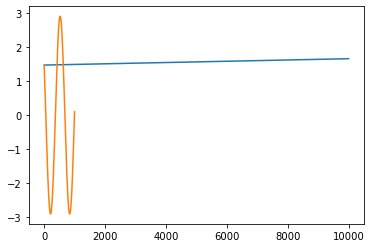

In [12]:
plt.plot(S_NODE.cpu().detach()[:,0,0])
plt.plot(x_test.cpu().detach()[0,:,0])

# delay embedding of the observations : 

In [13]:
def get_aug_data(X_train, tau, dim):
    aud_data=[X_train[(dim-1)*tau:].flatten()]
    for i in range(1,dim):
            aud_data.append(np.roll(X_train, i*tau)[(dim-1)*tau:].flatten())
    new_data = np.array(aud_data).T
    return new_data

In [14]:
dim_emb = 2
lag = 100
new_data = get_aug_data(x[0,:,:].cpu().numpy(), lag, dim_emb)

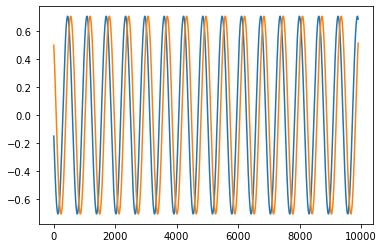

In [15]:
plt.plot(new_data)

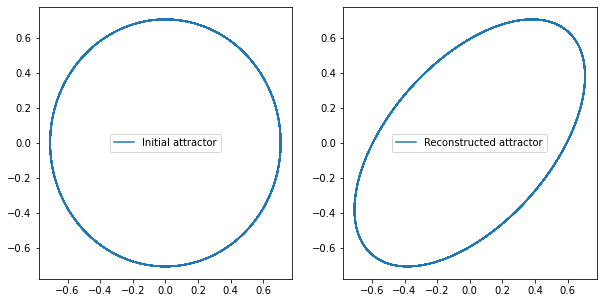

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

ax1.plot(True_sol.real,True_sol.imag,label = 'Initial attractor')
ax1.legend()
ax2.plot(new_data[:,0],new_data[:,1],label = 'Reconstructed attractor')
ax2.legend()

# delay embedding with bad embedding parameters

In [17]:
dim_emb = 2
lag = int(2*np.pi*(1/dt_integration))
new_data = get_aug_data(x[0,:,:].cpu().numpy(), lag, dim_emb)

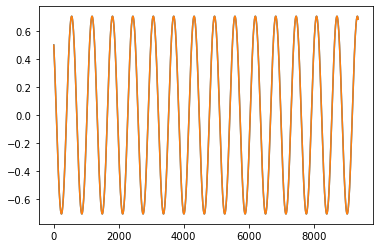

In [18]:
plt.plot(new_data)

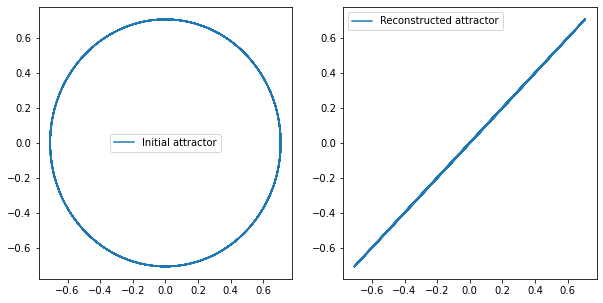

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

ax1.plot(True_sol.real,True_sol.imag,label = 'Initial attractor')
ax1.legend()
ax2.plot(new_data[:,0],new_data[:,1],label = 'Reconstructed attractor')
ax2.legend()

# Model the delay embedding (with good embedding parameters)

In [20]:
dim_emb = # choose a correct embedding dimension
lag     = # choose a correct lag 
new_data      = get_aug_data(x[0,:,:].cpu().numpy(), lag, dim_emb)
new_data_test = get_aug_data(x_test[0,:,:].cpu().numpy(), lag, dim_emb)

In [21]:
x = torch.from_numpy(new_data).float().unsqueeze(0)[:,:-1,:].to(device)
y = torch.from_numpy(new_data).float().unsqueeze(0)[:,1:,:].to(device)
x_test = torch.from_numpy(new_data_test).float().unsqueeze(0)[:,:-1,:].to(device)


In [22]:
device = 'cpu'
params = {}#NN parameters 
params['transition_layers']=5
params['bi_linear_layers']=3
params['dim_hidden_linear'] = 3
params['dim_input']=2
params['dim_observations'] = 2
params['dim_output']=2
params['dim_hidden']=5
params['dt_integration']=dt_integration
params['ntrain']=[4000]
params['pretrained']=False
params['path']='NODE_RK4_Lorend_dt_02'
params['lr']=0.001

In [23]:
model  = NODE_model(params).to(device)

In [24]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)

dt = dt_integration*np.arange(x.shape[1])
dt = torch.from_numpy(dt).float()
time  = dt[:2]

In [25]:
print ('Learning dynamical model')
for t in range(params['ntrain'][0]):
        for b in range(x.shape[0]):
            # Forward pass: Compute predicted gradients by passing x to the model
            pred = odeintTorch(model, x[b,:,:], time, method = 'rk4')#modelRINN(x[b,:,:],params['dt_integration'],order)
            loss = criterion(pred[1,:,:], y[b,:,:])
            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
print(t,loss)

Learning dynamical model
3999 tensor(6.4284e-14, grad_fn=<MseLossBackward0>)


In [26]:
init_cond   = x_test[0,:1,:].to(device)
S_NODE  = odeintTorch(model, init_cond, dt,method = 'rk4')

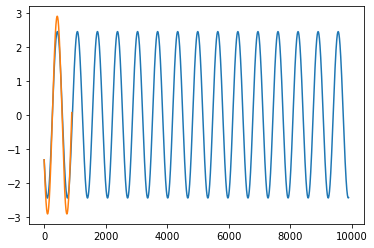

In [27]:
plt.plot(S_NODE.cpu().detach()[:,0,0])
plt.plot(x_test.cpu().detach()[0,:,0])